# Graphene with a single adatom

In [1]:
## import statements
import kwant
import tinyarray
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product
from mpl_toolkits.axes_grid1 import make_axes_locatable

FONT_LABELS = 20
# font = {'family' : 'serif', 'weight' : 'bold', 'size': FONT_LABELS}
font = {'size': FONT_LABELS}
mpl.rc('font', **font)
# plt.rc('text', usetex=True)

## Definition of the Graphene strip

Let's start by defining a system without SOC terms, but with two orbitals per site representing the spin. To do so, we've adopted the `general` lattice definition from `kwant.lattice` module. Such a function needs the primitive vectors and the coordinates of the basis atoms:

**Primitive vectors:**
* (1, 0)
* ($\sin 30°$, $\cos 30°$)

**Coordinates of basis atoms:**
* (0, 0)
* (0, $\frac{1}{\sqrt 3}$)

In [2]:
## Constants and important matrices
zeros_2x2 = tinyarray.array([[0,0],[0,0]])
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

g_Lande = 2
Magneton_Bohr = 5.788e-5 # eV/T

In [3]:
class Rectangle:
    """
    Class to define callable objects to define the 
    shape of the scattering region of a rectangular
    system.
    """
    def __init__(self, W, L):
        '''
        Calling the scattering region as strip:
        W = width of the strip
        L = length of the strip 
        '''
        self.W = W
        self.L = L
        
    def __call__(self, pos):
        W, L = self.W, self.L
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    def leads(self, pos):
        W = self.W
        _, y = pos
        return -W/2 < y < W/2

### Builder functions:

With the inclusion of the magnetic field, we have to change the way the **on-site** and the **hoppings** are defined: both will be field and position dependent now. As we have been done so far, we'll change these aspects one-by-one adopting the code without magnetic field (located in notebook `randomly_positioned_adatoms`) as a template.

#### Zeeman effect

In [4]:
class Bfield:
    def __init__(self, Bvalue, Length_centered):
        self.Bvalue = Bvalue
        self.L = Length_centered
        
    def __call__(self, x, y):
        return self.Bvalue if np.abs(x) <= self.L/2 else 0 

In [5]:
def on_site_with_Zeeman(site, V, B, Lm):
    """
    This function defines the on-site energy by
    allowing to pass functions of position for
    the electrical potential and the magnetic field
    separately in order to account for the Zeeman
    effect.
    """
    x, y = site.pos
    Bfunc = Bfield(Bvalue=B, Length_centered=Lm)
    H_Z = g_Lande * Magneton_Bohr/2 * Bfunc(x,y) * sigma_z
    return V * sigma_0 + H_Z

def on_site_H_with_Zeeman(site, eps_H, B, Lm):
    """
    This function defines the on-site energy by
    allowing to pass functions of position for
    the electrical potential and the magnetic field
    separately in order to account for the Zeeman
    effect.
    """
    x, y = site.pos
    Bfunc = Bfield(Bvalue=B, Length_centered=Lm)
    H_Z = g_Lande * Magneton_Bohr/2 * Bfunc(x,y) * sigma_z
    return eps_H * sigma_0 + H_Z

#### Peierls subbstitution

In [6]:
## POSITION DEPENDENT HOPPINGS
def hopping_by_hand(Site1, Site2, t, B, Lm, peierls):
    return -t * sigma_0 * peierls(Site1, Site2, B, Lm)

def peierls_1(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    x_i, x_j = change_x(x_i, Lm), change_x(x_j, Lm)
    theta = B/2 * (x_i + x_j) * (y_i - y_j)
    return np.exp(-1j*theta)

def peierls_lead_L(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    theta = -B/2 * Lm * (y_i - y_j)
    return np.exp(-1j*theta)

def peierls_lead_R(Site1, Site2, B, Lm):
    (x_i, y_i) = Site1.pos # Target
    (x_j, y_j) = Site2.pos # Source
    theta = B/2 * Lm * (y_i - y_j)
    return np.exp(-1j*theta)

def change_x(x, Lm):
    if (-Lm/2) <= x <= (Lm/2): return x
    elif x > (Lm/2): return Lm/2
    else: return -Lm/2

In [7]:
class HoppingFunction(object):
    
    def __init__(self, B_0_hopping, sign):
        self.B_0_hopping = B_0_hopping
        self.sign = sign
        
    def __call__(self, site1, site2, B, Lm, peierls):
        return self.sign * self.B_0_hopping * peierls(site1, site2, B, Lm)

In [8]:
def include_ISOC(system, G_sub_lattices, lambda_I=1):
    """
    ## INCLUDING THE INTRINSIC SOC (isoc):
    system         := kwant.builder.Builder
    G_sub_lattices := list of Graphene sublattices
    lambda_I       := parameter
    """
    sub_a, sub_b = G_sub_lattices
    # lambda_I   = 1 ## non-realistic; see reference: PRL 110, 246602 (2013)
    
    H_isoc_matrix = -1j/3 * lambda_I/np.sqrt(3) * sigma_z # counter-clockwise
    
    H_isoc_p = HoppingFunction(B_0_hopping=H_isoc_matrix, sign=+1)
    H_isoc_m = HoppingFunction(B_0_hopping=H_isoc_matrix, sign=-1)
    
    system[kwant.builder.HoppingKind((1,0), sub_a, sub_a)]  = H_isoc_p
    system[kwant.builder.HoppingKind((0,1), sub_a, sub_a)]  = H_isoc_m
    system[kwant.builder.HoppingKind((-1,1), sub_a, sub_a)] = H_isoc_p
    system[kwant.builder.HoppingKind((1,0), sub_b, sub_b)]  = H_isoc_p
    system[kwant.builder.HoppingKind((0,1), sub_b, sub_b)]  = H_isoc_p
    system[kwant.builder.HoppingKind((-1,1), sub_b, sub_b)] = H_isoc_m

In [9]:
def make_graphene_strip(lattice, scatter_shape, t=1, iso=1e-6):
    
#     sym = kwant.TranslationalSymmetry(graphene.vec((1, 0)), graphene.vec((0, 1)))
    
#     syst = kwant.Builder(sym)
    syst = kwant.Builder()
    syst[lattice.shape(scatter_shape, (0, 0))] = on_site_with_Zeeman  # this is a func. of Bfield and pos.

    # Specify the hoppings for graphene lattice in the
    # format expected by builder.HoppingKind
    a, b = lattice.sublattices
    hoppings_list = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    
#     hopping = t * sigma_0
    
    syst[[kwant.builder.HoppingKind(*hop) for hop in hoppings_list]] = hopping_by_hand
    syst.eradicate_dangling()
    
    include_ISOC(syst, [a,b], lambda_I=iso)
    
    return syst

In [10]:
def make_graphene_leads(lattice, lead_shape, t=1, on_site=0, iso=1e-6):
    a, b = lattice.sublattices
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(a, other_vectors=[(-1,2)])
    symmetry.add_site_family(b, other_vectors=[(-1,2)])

    lead_0 = kwant.Builder(symmetry)
    lead_0[lattice.shape(lead_shape, (0,0))] = zeros_2x2

    hoppings_list = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
#     hopping = t * sigma_0
    lead_0[(kwant.builder.HoppingKind(*hop) for hop in hoppings_list)] = hopping_by_hand
    lead_0.eradicate_dangling()
    include_ISOC(lead_0, [a,b], lambda_I=iso)

    lead_1 = lead_0.reversed()
    
    lead_0 = lead_0.substituted(peierls='peierls_lead_L')
    lead_1 = lead_1.substituted(peierls='peierls_lead_R')

    return [lead_0, lead_1]

## Parameters

In [11]:
parameters_wo_adatom_wo_B = dict(V=0,
                       t=2.6,
                       B=0,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )

parameters_wo_B = dict(V=0,
                       t=2.6,
                       B=0,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=3,
                    )


## Density of states without Adatom

In [12]:
# Make the system
sin_30 = 1/2
cos_30 = np.sqrt(3)/2

graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site (spin)
                                 name='Graphene'                       # name of identification
                                )
## Split in sublattices:
A, B = graphene.sublattices

## Define the shape of the system:
shape = Rectangle(W=10, L=50)

## Build the scattering region:
system = make_graphene_strip(graphene, shape, t=2.6, iso=1e-6)

## Make the leads:
leads  = make_graphene_leads(graphene, shape.leads, t=1, on_site=0, iso=1e-6)

## Attach the leads:
for lead in leads:
    system.attach_lead(lead)

In [13]:
fsystem = system.finalized() ## Finalize the system
spectrum_wo_adatom_wo_B = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_adatom_wo_B)
# spectrum.add_moments(energy_resolution=0.03)

In [14]:
energies, densities = spectrum_wo_adatom_wo_B()
energies_subset_wo_adatom_wo_B = np.linspace(-7.9, 7.9, 501)
densities_subset_wo_adatom_wo_B = spectrum_wo_adatom_wo_B(energies_subset_wo_adatom_wo_B)

/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/kpm.py:281: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


Text(0, 0.5, 'DOS [a.u.]')

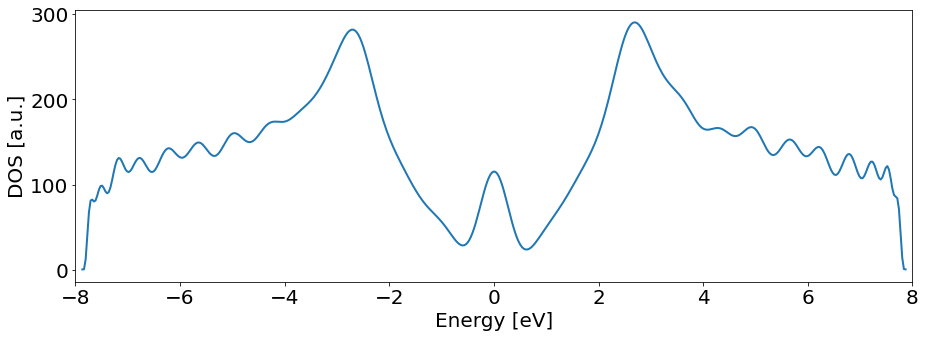

In [15]:
figure, ax = plt.subplots(figsize=(15,5))

# ax.plot(energies, densities.real)
ax.plot(energies_subset_wo_adatom_wo_B, densities_subset_wo_adatom_wo_B.real, lw=2)
ax.set_xlim(-8,8)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('DOS [a.u.]')


In [16]:
fsystem = system.finalized()

center_tag = np.array([0, 0])
where = lambda s: s.tag == center_tag
vector_factory = kwant.kpm.LocalVectors(fsystem, where)

spectrum_center_wo_adatom = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_adatom_wo_B, num_vectors=None,
                                          vector_factory=vector_factory,
                                          mean=True)
# spectrum.add_moments(100)
# spectrum.add_moments(energy_resolution=0.01)

# energies, densities = spectrum_center_wo_adatom()

energies_subset_center_wo_adatom = np.linspace(-8,8,501)
densities_subset_center_wo_adatom = spectrum_center_wo_adatom(energies_subset_center_wo_adatom)

/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/kpm.py:281: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


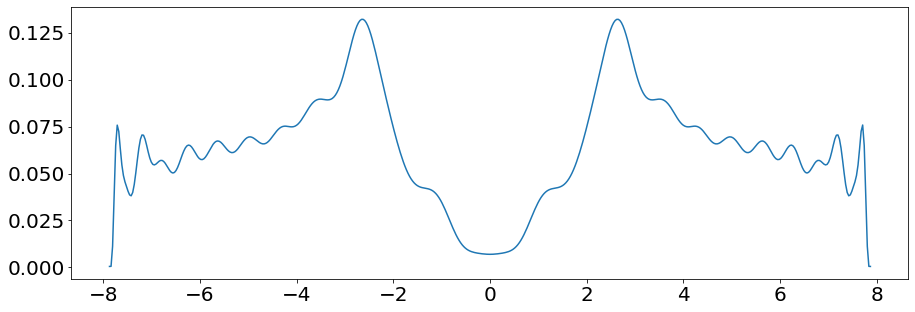

In [17]:
plt.figure(figsize=(15,5))
# plt.plot(energies, densities.real)
plt.plot(energies_subset_center_wo_adatom, densities_subset_center_wo_adatom.real)
# plt.ylim(1000, 7000)
# plt.xlim(-1.5, 1.5)

In [18]:
kwant_op = kwant.operator.Density(fsystem, sum=False)
local_dos = kwant.kpm.SpectralDensity(fsystem, operator=kwant_op, params=parameters_wo_adatom_wo_B)
local_dos.add_vectors(100)

In [19]:
zero_energy_ldos_wo_adatom = local_dos(energy=0)
finite_energy_ldos_wo_adatom = local_dos(energy=1)

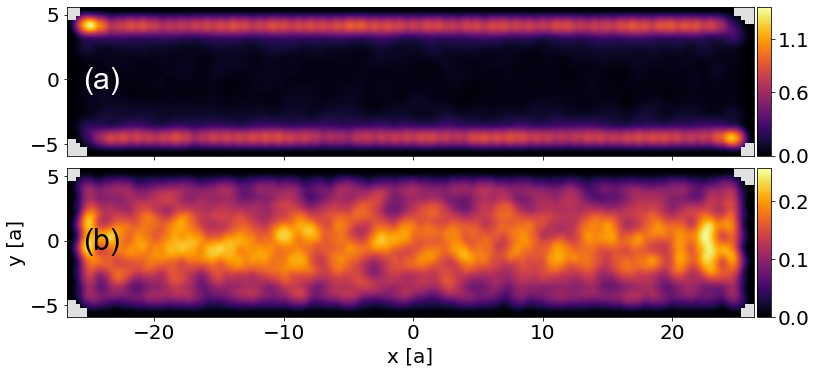

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
kwant.plotter.density(fsystem, zero_energy_ldos_wo_adatom.real, ax=axes[0], cmap='inferno')
kwant.plotter.density(fsystem, finite_energy_ldos_wo_adatom.real, ax=axes[1], cmap='inferno')
axes[0].get_xaxis().set_ticklabels([])
axes[0].text(0.05, 0.6,'(a)',
           color='w',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[0].transAxes)
axes[1].text(0.05, 0.6,'(b)',
           color='k',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[1].transAxes)
axes[1].set_xlabel('x [a]', fontsize=20)
axes[1].set_ylabel('y [a]', fontsize=20)

ldos_map1, = axes[0].images
ldos_map2, = axes[1].images

divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="2%", pad=0.05)

divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="2%", pad=0.05)

plt.colorbar(ldos_map1, cax=cax1, ticks=[.0, .6, 1.1])
plt.colorbar(ldos_map2, cax=cax2,)
plt.tight_layout(pad=0.)


# plt.savefig('ldos_E_0_and_E_1_without_adatom.png', dpi=200)
plt.show()

### With $B\neq 0$

In [21]:
parameters_wo_adatom_with_B = dict(V=0,
                       t=2.6,
                       B=2*np.pi,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=100,
                    )

In [22]:
fsystem = system.finalized() ## Finalize the system

energies_subset_wo_adatom_with_B = np.linspace(-6,6,501)

parameters_wo_adatom_with_B['B'] = 0.05 * np.pi
spectrum_wo_adatom_with_B = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_adatom_with_B)
densities_subset_wo_adatom_with_B_1 = spectrum_wo_adatom_with_B(energies_subset_wo_adatom_wo_B)

parameters_wo_adatom_with_B['B'] = 0.1 * np.pi
spectrum_wo_adatom_with_B = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_adatom_with_B)
densities_subset_wo_adatom_with_B_2 = spectrum_wo_adatom_with_B(energies_subset_wo_adatom_wo_B)

parameters_wo_adatom_with_B['B'] = 0.25 * np.pi
spectrum_wo_adatom_with_B = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_adatom_with_B)
densities_subset_wo_adatom_with_B_3 = spectrum_wo_adatom_with_B(energies_subset_wo_adatom_wo_B)

/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/kpm.py:281: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


Text(0, 0.5, 'DOS [a.u.]')

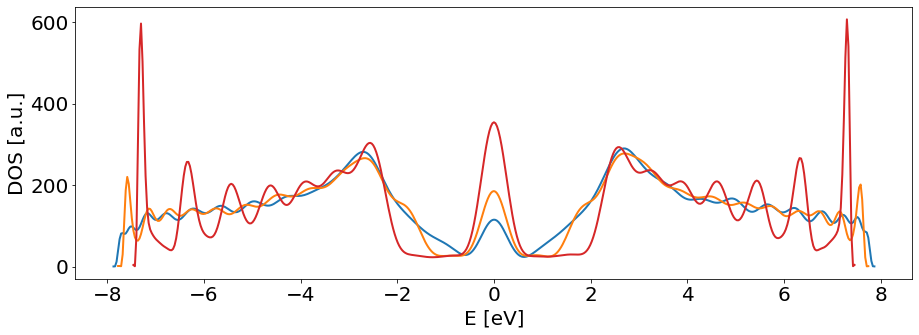

In [23]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(energies_subset_wo_adatom_wo_B, 
        densities_subset_wo_adatom_wo_B.real, lw=2, label=r'$B=0$')
# ax.plot(energies_subset_wo_adatom_wo_B, 
#         densities_subset_wo_adatom_with_B_1.real, lw=2, ls='--', c='b')
ax.plot(energies_subset_wo_adatom_wo_B, 
        densities_subset_wo_adatom_with_B_2.real, lw=2, ls='-', label=r'$B=0$')
ax.plot(energies_subset_wo_adatom_wo_B, 
        densities_subset_wo_adatom_with_B_3.real, lw=2, c='C3', label=r'$B=0$')

ax.set_xlabel('E [eV]', fontsize=20)
ax.set_ylabel('DOS [a.u.]', fontsize=20)

# plt.plot(energies_subset, densities_subset.real)
# plt.ylim(0,500)

In [24]:
kwant_op = kwant.operator.Density(fsystem, sum=False)
local_dos = kwant.kpm.SpectralDensity(fsystem, operator=kwant_op, params=parameters_wo_adatom_with_B)
local_dos.add_vectors(100)

In [25]:
zero_energy_ldos_wo_adatom = local_dos(energy=0)
finite_energy_ldos_wo_adatom = local_dos(energy=1.5)

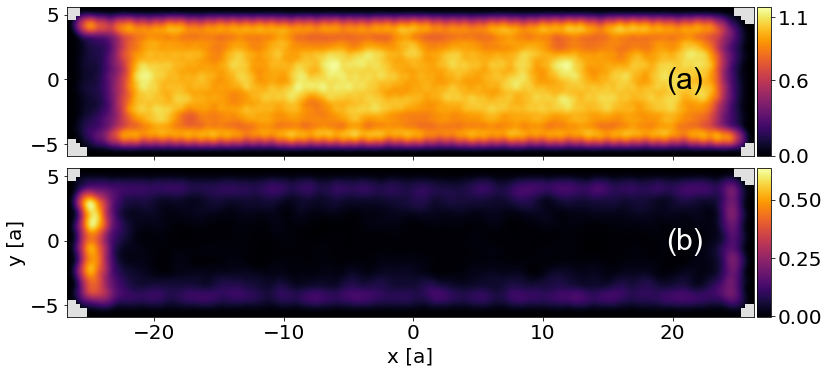

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
kwant.plotter.density(fsystem, zero_energy_ldos_wo_adatom.real, ax=axes[0], cmap='inferno')
kwant.plotter.density(fsystem, finite_energy_ldos_wo_adatom.real, ax=axes[1], cmap='inferno')
axes[0].get_xaxis().set_ticklabels([])
axes[0].text(0.90, 0.6,'(a)',
           color='k',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[0].transAxes)
axes[1].text(0.90, 0.6,'(b)',
           color='w',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[1].transAxes)
axes[1].set_xlabel('x [a]', fontsize=20)
axes[1].set_ylabel('y [a]', fontsize=20)

ldos_map1, = axes[0].images
ldos_map2, = axes[1].images

divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="2%", pad=0.05)

divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="2%", pad=0.05)

plt.colorbar(ldos_map1, cax=cax1, ticks=[.0, .6, 1.1])
plt.colorbar(ldos_map2, cax=cax2,)
plt.tight_layout(pad=0.)


# plt.savefig('ldos_E_0_and_E_1_without_adatom.png', dpi=200)
plt.show()

**Why we have a concentration on the left hand side of the system?**

## Placing the adatom and chaging the hopping properly

We want to place a single Hydrogen-atom on top of a specified Graphene site. As a criteria, we want to avoid the sites at the interface between the scattering system and the leads. Currently it is not possible to place an adatom at the boundaries of the strip, but it will be changed soon.

Since our system presents altered hoppings between next-nearest-neighbors, the sites allowed to host H-adatoms has to be at least one primitive vector away from the boundaries of the system. Now our tasks are, given the chosen C$_H$ atom (host Carbon atom),

1. to collect the nearest-neighbors (nn) and the next-nearest-neighbor (nnn) of C$_H$,
2. given the C$_H$, its nn and its nnn, to change the hoppings

### Defining the "pseudo-lattice" for H-atoms:

In [27]:
hydrogen = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site (spin)
                                 name='H'                              # name for identification
                                )
## Split in sublattices
HA, HB = hydrogen.sublattices

### Geetting the neighbors

In [28]:
## Getting the neighboring sites
def get_neighbors(system, C_H_site):
    site_tag = C_H_site.tag
    site_sub = C_H_site.family
    nn_list = get_nn(system, site_tag, site_sub)
    nnn_list = get_nnn(system, site_tag, site_sub)
    return nn_list, nnn_list

def get_nn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice

    Notice that
    """
    list_sub_lat = [A, B]
    list_sub_lat.remove(sub_s)
    sub_nn, = list_sub_lat
    # print(sub_nn.name[-1])
    name_indx = int(sub_s.name[-1])
    delta = +1 if name_indx == 0 else -1
    i,j = tag
    nn_tag_list = [(i,j), (i+delta,j-delta), (i,j-delta)]
    nn_sites = [
        sub_nn(*t) for t in nn_tag_list if sub_nn(*t) in system
    ]
    return nn_sites

def get_nnn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice

    Notice that
    """
    #sub_nnn = sub_s

    i,j = tag
    nnn_tag_list = [(  i,j+1), (i+1,  j),
                    (i+1,j-1), (  i,j-1),
                    (i-1,  j), (i-1,j+1)]
    nnn_sites = [
        sub_s(*t) for t in nnn_tag_list if sub_s(*t) in system
    ]
#     for site in nnn_sites:
#         print(site)
    return nnn_sites

### Induced SOC

$$
H_{ASO} = \frac{i}{3}\sum_{\langle\langle C_H, j \rangle\rangle} A^{\dagger}_{\sigma}c_{j,\sigma^{\prime}} \left[ \frac{\Lambda_I}{\sqrt{3}} \nu_{C_H, j} \hat{s}_z \right]_{\sigma, \sigma^{\prime}}
$$


$$
H_{BR} = \frac{2i}{3} \sum_{\langle C_H, j \rangle} A^{\dagger}_{\sigma}B_{j\sigma^{\prime}} \left[\Lambda_{BR} (\hat{s} \times \vec{d}_{C_H, j})_z\right]_{\sigma,\sigma^{\prime}}
$$

$$
H_{PIA} = \frac{2i}{3} \sum_{\langle\langle i,j \rangle\rangle} B^{\dagger}_{i\sigma}B_{j\sigma^{\prime}}[\Lambda_{PIA}(\hat{s}\times\vec{D}_{ij})_{z}]_{\sigma\sigma^{\prime}}
$$

[PRL 110, 246602 (2013)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.110.246602) 

In [29]:
## Changing the hoppings around the adatom
def include_ASO_sitewise(system, CH_site, NNN_site, Lambda_I=1):
    """
    Define and replace the hopping between CH_site and one of its NNN sites,
    which is identified here as NNN_site.
    """
    # 1.1. Identify the hopping 1/2
    delta_tag = list(NNN_site.tag - CH_site.tag)
    if delta_tag in ([0,1], [1,-1], [-1,0]): sign = -1
    else: sign = +1

    # 1.2. Identify the hopping 2/2
    family_id  = 1 - 2 * int(CH_site.family.name[-1]) ## 1 (-1) if sublattice == A (B)

    # 3. Define the hopping
    H_asoc_matrix = family_id * 1j/3 * Lambda_I/np.sqrt(3) * sigma_z # clockwise
    H_asoc = HoppingFunction(B_0_hopping=H_asoc_matrix, sign=sign)
    
    system[CH_site, NNN_site] = H_asoc

def include_BR_sitewise(system, CH_site, NN_site, t=1, Lambda_BR=1):
    """
    Update the hopping between the CH_site and the NN_site to include
    the Bychkov-Rashba SOC.
    """
    # 1. Identify the hopping 2/2:
    dx, dy = np.sqrt(3) * (CH_site.pos - NN_site.pos)
    
    
    
    H_hop_matrix = t * sigma_0
    H_BR_matrix = (2j/3) * Lambda_BR * (dy * sigma_x - dx * sigma_y) ## (S X d_ij)_z
    
    H_matrix = H_hop_matrix + H_BR_matrix
    
    H_BR = HoppingFunction(B_0_hopping = H_matrix, sign=+1)
    
    
    # 2. Define the hopping
    system[CH_site, NN_site] = H_BR

def include_PIA_sitewise(system, site_target, site_source, lambda_I=1, Lambda_PIA=1):
    """
    Define the PIA hopping and add to the already existent hopping between
    site_target and site_source.
    """
    # 1.1 Identify the hopping 1/2:
    Dx, Dy = site_target.pos - site_source.pos
    
    # 1.2 Identify the hopping 2/2:
    delta_tag = site_target.tag - site_source.tag
    
    # 2. ISO
    sites_family = site_target.family
    if sites_family == A and delta_tag in ([0,1], [1,-1], [-1,0]):
        H_iso_matrix = 1j/3 * lambda_I/np.sqrt(3) * sigma_z
    elif sites_family == B and delta_tag in ([0,-1], [-1,+1], [1,0]):
        H_iso_matrix = 1j/3 * lambda_I/np.sqrt(3) * sigma_z
    else:
        H_iso_matrix = -1j/3 * lambda_I/np.sqrt(3) * sigma_z

    # 3. PIA:
    H_PIA_matrix =  2j/3 * Lambda_PIA * (Dy * sigma_x - Dx * sigma_y) ## (S x D_ij)_z
    
    # 4. Total hopping:
    H_PIA_ISO = HoppingFunction(B_0_hopping = (H_iso_matrix + H_PIA_matrix), sign=+1) 
    
    system[site_target, site_source] = H_PIA_ISO

In [30]:
## Inserting adatom:
def insert_adatom(syst, pos_tag, sub_lat, t=1, l_iso=1, T=1, L_I=1, L_BR=1, L_PIA=1):
    if sub_lat == A:
        site_CH = A(*pos_tag)
        site_H = HA(*pos_tag)
    elif sub_lat == B:
        site_CH = B(*pos_tag)
        site_H = HB(*pos_tag)

    ## On-site:
    syst[site_H] = on_site_H_with_Zeeman
    ## Hopping:
    syst[site_H, site_CH] = T * sigma_0
    ## Neighbors
    nn_sites, nnn_sites = get_neighbors(syst, site_CH)

    ## Calculate and include the Adatom induced spin-orbit coupling
    for site in nnn_sites:
        include_ASO_sitewise(syst, site_CH, site, Lambda_I=L_I)

    ## Calculate and include into the system the Bychkov-Rashba spin-orbit coupling (BR)
    for site in nn_sites:
        include_BR_sitewise(syst, site_CH, site,t=t, Lambda_BR=L_BR)

    ## Calculate and include into the system the Pseudo-spin inversion asymmetry spin-orbit coupling (PIA)
    targets = [nn_sites[(i+1)%3] for i in range(3)]
    for site1, site2 in zip(targets, nn_sites):
        include_PIA_sitewise(syst, site1, site2, lambda_I=l_iso, Lambda_PIA=L_PIA)

In [31]:
pos_tag = (0,0)  # tag for the adatom
sub_lat = A      # sublattice of adatom
# adatom_params = dict(t = 2.6, l_iso = 12e-6, T = 7.5, L_I = -0.21e-3, L_BR = 0.33e-3, L_PIA = -0.77e-3)
adatom_params = dict(t = 2.6, l_iso = 12e-6, T = 7.5, L_I = -0.21e-3, L_BR = 0.33e-3, L_PIA = -0.77e-3)

In [32]:
insert_adatom(system, pos_tag, sub_lat,  **adatom_params)

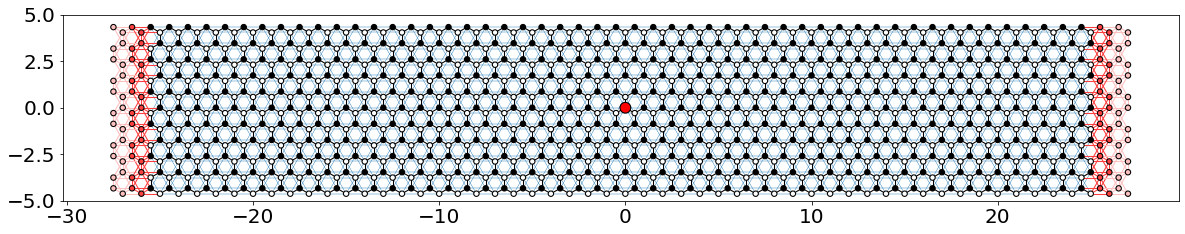

In [33]:
## System:
def family_colors(site):
        if site.family == A:
            color = 'k'
        elif site.family == B:
            color = 'w'
        elif site.family == HA:
            color = 'red'
        elif site.family == HB:
            color = 'red'
        else:
            color = 'magenta'
        return color

def hopping_colors(site1, site2):
        if site1.family == site2.family:
            color='C0'
        else:
            color='black'
        return color

def hopping_lw(site1, site2):
    return 0.04 if site1.family == site2.family else 0.1
    
def family_size(site):
    return 0.5 if (site.family==HA or site.family==HB) else 0.25
    
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_size = family_size,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
# ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
# plt.savefig('system_long.png', dpi=200)
plt.show()

In [34]:
fsystem = system.finalized() ## Finalize the system
spectrum_with_adatom = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_B)
# spectrum.add_moments(energy_resolution=0.03)

energies, densities_with_adatom = spectrum_with_adatom()
energies_subset_with_adatom = np.linspace(-9.8,9.8,501)
densities_subset_with_adatom = spectrum_with_adatom(energies_subset_with_adatom)

/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/kpm.py:281: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


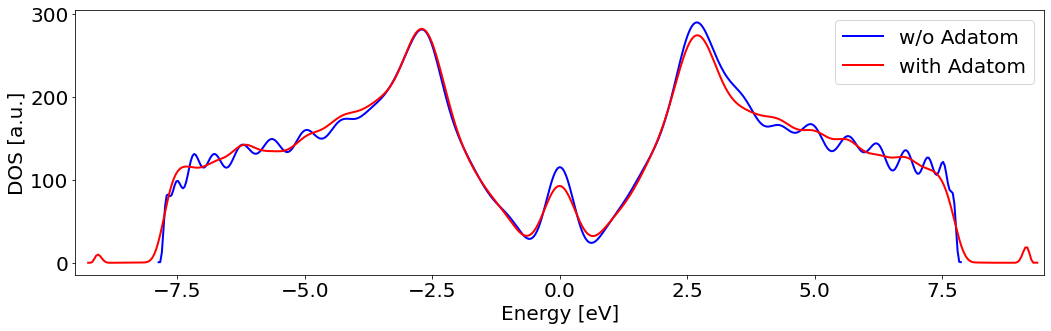

In [35]:
# plt.plot(energies, densities_with_adatom.real)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(energies_subset_wo_adatom_wo_B, densities_subset_wo_adatom_wo_B.real, c='b', lw=2, label='w/o Adatom')
ax.plot(energies_subset_with_adatom, densities_subset_with_adatom.real, c='r', lw=2, label='with Adatom')
ax.legend(fontsize = 20)
ax.set_xlim(-9.5, 9.5)

ax.set_xlabel('Energy [eV]')
ax.set_ylabel('DOS [a.u.]')
plt.tight_layout()
# plt.savefig('total_dos_comparison.png', dpi=200)

In [36]:
fsystem = system.finalized()

# center_radius = 10
# where = lambda s: s.pos[0]**2 + s.pos[1]**2 <= center_radius**2

# where = lambda s: s.pos[0] == 0 and s.pos[1] <= center_radius

center_tag = np.array([0, 0])
where = lambda s: s.pos == center_tag

vector_factory = kwant.kpm.LocalVectors(fsystem, where)

spectrum_with_adatom_center = kwant.kpm.SpectralDensity(fsystem, params=parameters_wo_B, num_vectors=None,
                                          vector_factory=vector_factory,
                                          mean=True)
# # spectrum.add_moments(100)
# # spectrum.add_moments(energy_resolution=0.01)

# energies, densities_with_adatom_center = spectrum_with_adatom_center()


energies_subset_with_adatom_center = np.linspace(-10,10,501)
densities_subset_with_adatom_center = spectrum_with_adatom_center(energies_subset_with_adatom_center)

/home/marcos/anaconda3/envs/kwant/lib/python3.8/site-packages/kwant/kpm.py:281: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


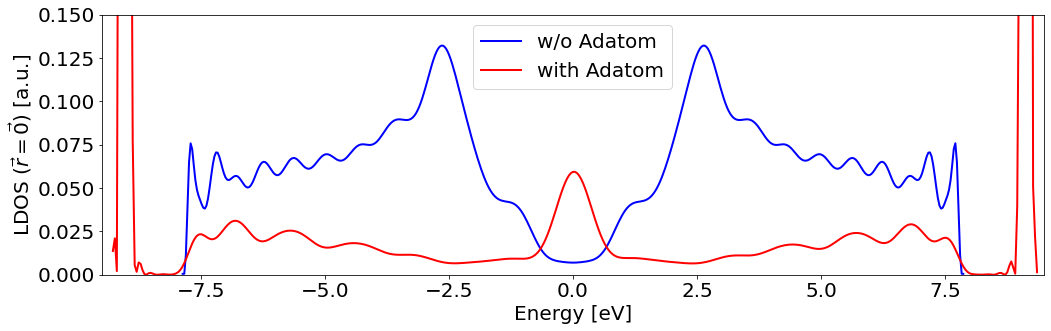

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(energies_subset_center_wo_adatom, densities_subset_center_wo_adatom.real, c='b', lw=2, label='w/o Adatom')
ax.plot(energies_subset_with_adatom_center, densities_subset_with_adatom_center.real, c='r', lw=2, label='with Adatom')
ax.set_ylim(0, 0.15)
ax.set_xlim(-9.5, 9.5)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel(r'LDOS $(\vec{r} = \vec{0})$ [a.u.]')
ax.legend(fontsize=20)
plt.tight_layout()
# plt.savefig('ldos_at_center_comparison.png', dpi=200)

In [38]:
kwant_op = kwant.operator.Density(fsystem, sum=False)
local_dos_with_adatom = kwant.kpm.SpectralDensity(fsystem, operator=kwant_op, params=parameters_wo_B)
local_dos_with_adatom.add_vectors(100)

In [39]:
energy_peak = 9.17
zero_energy_ldos_with_adatom = local_dos_with_adatom(energy=0)
finite_energy_ldos_with_adatom = local_dos_with_adatom(energy=energy_peak)

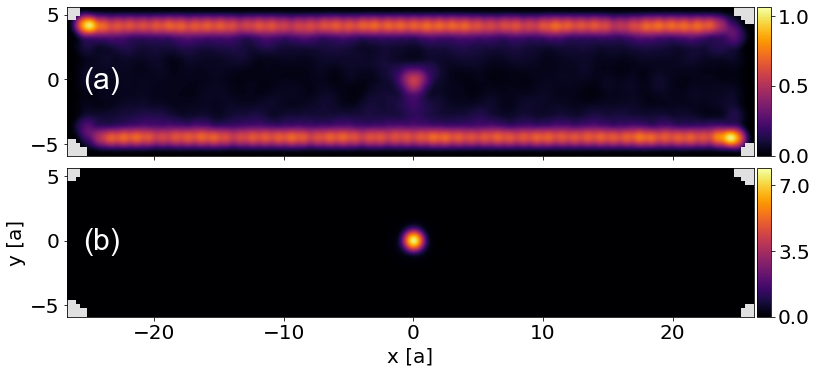

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
# ldos_map1 = kwant.plotter.density(fsystem, zero_energy_ldos_with_adatom.real, cmap='inferno')
kwant.plotter.density(fsystem, zero_energy_ldos_with_adatom.real, ax=axes[0], cmap='inferno')
kwant.plotter.density(fsystem, finite_energy_ldos_with_adatom.real, ax=axes[1], cmap='inferno', colorbar=True)
axes[0].get_xaxis().set_ticklabels([])
axes[0].text(0.05, 0.6,'(a)',
           color='w',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[0].transAxes)
axes[1].text(0.05, 0.6,'(b)',
           color='w',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[1].transAxes)
axes[1].set_xlabel('x [a]', fontsize=20)
axes[1].set_ylabel('y [a]', fontsize=20)
ldos_map1, = axes[0].images
ldos_map2, = axes[1].images

divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="2%", pad=0.05)

divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="2%", pad=0.05)

plt.colorbar(ldos_map1, cax=cax1, ticks=[0, .5, 1.0])
plt.colorbar(ldos_map2, cax=cax2, ticks=[0, 3.5, 7.0])
plt.tight_layout(pad=0.0)
# plt.savefig('ldos_E_0_and_E_9,17_with_adatom.png', dpi=200)
plt.show()

In [41]:
parameters_B = dict(V=0,
                       t=2.6,
                       B=2*np.pi,
                       eps_H=0.16,
                       peierls=peierls_1,
                       peierls_lead_L=peierls_lead_L,
                       peierls_lead_R=peierls_lead_R,
                       Lm=100,
                    )

In [42]:
spectrum_with_adatom_and_B = kwant.kpm.SpectralDensity(fsystem, params=parameters_B)
# spectrum.add_moments(energy_resolution=0.03)

energies_adatom_B, densities_adatom_B = spectrum_with_adatom_and_B()
# energies_subset_with_adatom = np.linspace(-9.8,9.8,501)
# densities_subset_with_adatom = spectrum_with_adatom(energies_subset_with_adatom)

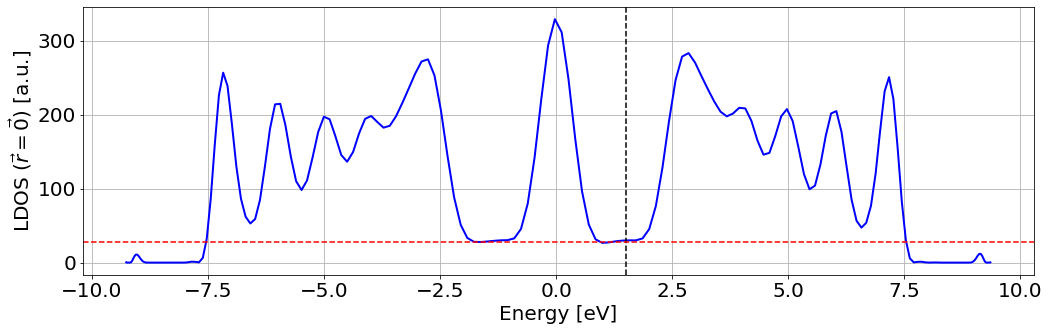

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(energies_adatom_B, densities_adatom_B.real, lw=2, c='b')
ax.axvline(x=1.5, ls='--', c='k')
ax.axhline(y=28.0, ls='--', c='r')
ax.grid()
ax.set_xlabel('Energy [eV]')
ax.set_ylabel(r'LDOS $(\vec{r} = \vec{0})$ [a.u.]')
# ax.legend(fontsize=20)
plt.tight_layout()
# plt.savefig('ldos_magnetic_with_adatom.png', dpi=200)

In [44]:
kwant_op = kwant.operator.Density(fsystem, sum=False)
local_dos_adatom_B = kwant.kpm.SpectralDensity(fsystem, operator=kwant_op, params=parameters_B)
local_dos_adatom_B.add_vectors(100)

zero_energy_ldos_adatom_B = local_dos_adatom_B(energy=0)
finite_energy_ldos_adatom_B = local_dos_adatom_B(energy=-1.5)

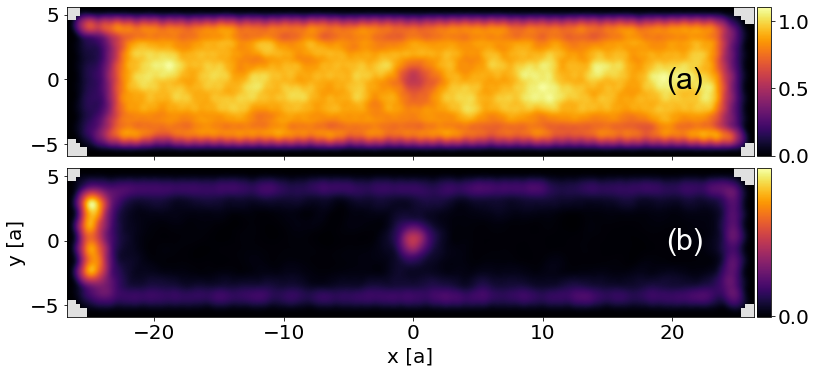

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
# ldos_map1 = kwant.plotter.density(fsystem, zero_energy_ldos_with_adatom.real, cmap='inferno')
kwant.plotter.density(fsystem, zero_energy_ldos_adatom_B.real, ax=axes[0], cmap='inferno')
kwant.plotter.density(fsystem, finite_energy_ldos_adatom_B.real, ax=axes[1], cmap='inferno', colorbar=True)
axes[0].get_xaxis().set_ticklabels([])
axes[0].text(0.90, 0.6,'(a)',
           color='k',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[0].transAxes)
axes[1].text(0.90, 0.6,'(b)',
           color='w',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = axes[1].transAxes)
axes[1].set_xlabel('x [a]', fontsize=20)
axes[1].set_ylabel('y [a]', fontsize=20)
ldos_map1, = axes[0].images
ldos_map2, = axes[1].images

divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="2%", pad=0.05)

divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="2%", pad=0.05)

plt.colorbar(ldos_map1, cax=cax1, ticks=[0, .5, 1.0])
plt.colorbar(ldos_map2, cax=cax2, ticks=[0, 3.5, 7.0])
plt.tight_layout(pad=0.0)
# plt.savefig('ldos_E_0_and_E_9,17_adatom_B.png', dpi=200)
plt.show()

## Diferent way to calculate the density-of-states

By definition, the total density-of-states is given by

$$
    D(E) = \sum_m \delta(E-E_m),
$$

since

$$
    \frac{1}{\pi}\lim_{\varepsilon \rightarrow 0^+} \frac{\varepsilon}{(E-E_m)^2+\varepsilon^2} = \delta(E-E_m) 
$$



In [46]:
import numpy.linalg as la

In [47]:
def delta_approx(E, Em, eps):
    return (eps/np.pi)/((E-Em)**2 + eps**2)

def DOS_manual(E_array, Eigenvalues, eps=0.1):
    dos = np.zeros_like(E_array)
    for Em in Eigenvalues:
        dos += delta_approx(E_array, Em, eps)
    return dos

In [48]:
## Define the shape of the system:
shape = Rectangle(W=50, L=50)

## Build the scattering region:
system_test = make_graphene_strip(graphene, shape, t=2.6, iso=1e-6)

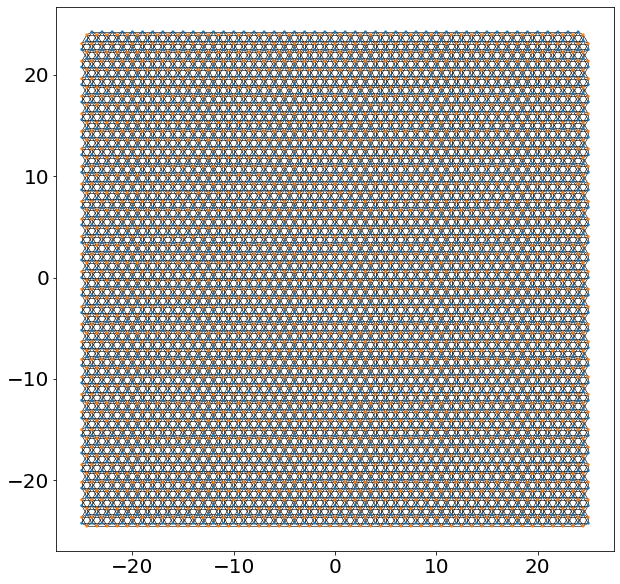

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
kwant.plot(system_test, ax=ax);
ax.set_aspect('equal')

In [50]:
Energies = np.linspace(-10,10,5001)

In [51]:
Hmatrix_test = system_test.finalized().hamiltonian_submatrix(params=parameters_wo_B)

In [52]:
Hmatrix_test.shape

(11510, 11510)

In [53]:
# values, vectors = la.eigh(Hmatrix_test) ## it take a lot of time

In [66]:
# np.savez('eigenvalues_W_50_L_50.npz', eigvalues=values)
data_W50_L50 = np.load('eigenvalues_W_50_L_50.npz')
values = data_W50_L50['eigvalues']

In [67]:
dos_test = DOS_manual(Energies, values, eps=0.05)

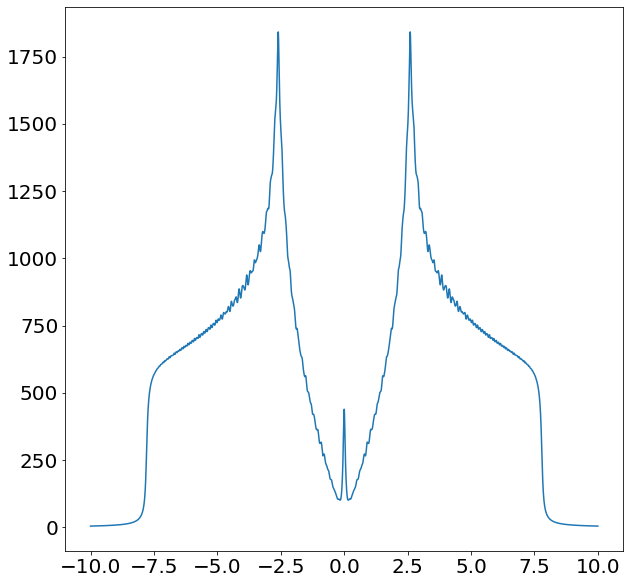

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Energies, dos_test, '-')

In [69]:
Hmatrix = fsystem.hamiltonian_submatrix(params=parameters_wo_B)

In [71]:
values_fsystem, _ = la.eigh(Hmatrix)

In [72]:
print("Matrix shape   = ", Hmatrix.shape)
print("# of values    = ",values_fsystem.shape)

Matrix shape   =  (2246, 2246)
# of values    =  (2246,)


In [73]:
dos_test_fsystem = DOS_manual(Energies, values_fsystem, eps=0.2)

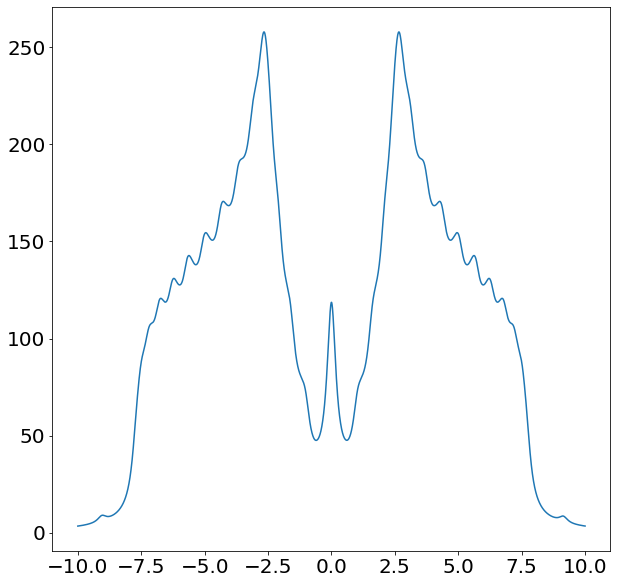

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Energies, dos_test_fsystem, '-')

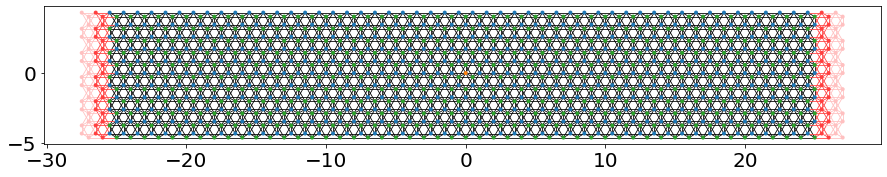

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
kwant.plot(fsystem, ax=ax)
# ax.set_xlim(-10,10)

In [78]:
class Hexagon:
    def __init__(self, side, center=(0,0), zigzag=False):
        """
        The side adustment guarantee that the armchair flake
        will have the minimum number of zigzag edge sites possible.
        """
        self.side   = side
        arm_control = 1-(side // (1/np.sqrt(3))) % 3
        self.side_adjusted = side + arm_control * (1/np.sqrt(3))
        self.center = center
        self.zigzag = zigzag
        
    def side_factors(self, pos):
        """
        This function return an array with signs (+1 or -1)
        that represent the location of the argument point.
        
        These "side_factors" are obtained by replacing 
        the coordinates of the point into the line equations 
        that define the sides of the hexagon and collecting the
        sign of the result of each side-defining equation.
        
        Each side of the figure splits the plane in two parts,
        the sign of the value returned by the line equation will
        say in which side of the line the point is located.
        
        """
        zigzag = self.zigzag
        side = self.side_adjusted
        x, y = pos
        x_center, y_center = self.center
        if zigzag:
            x, y = -y, x  
            x_center, y_center = -y_center, x_center
        factors = [+np.sqrt(3)/3 * (x-x_center) + (y-y_center) - side,
                   -np.sqrt(3)/3 * (x-x_center) + (y-y_center) + side,
                   -np.sqrt(3)/3 * (x-x_center) + (y-y_center) - side,
                   +np.sqrt(3)/3 * (x-x_center) + (y-y_center) + side,
                    (x-x_center) + np.sqrt(3)/2 * side,
                    (x-x_center) - np.sqrt(3)/2 * side,
                  ]
        return np.sign(factors)
        
    def __call__(self, pos):
        """
        This is a boolean function that returns
        'True' if the point defined by the tuple 
            pos = (x, y)
        is contained by the hexagon or 'False'
        otherwise.
        
        Comparing the 'side_factors' of the position
        and the center point we can say if the point
        is inside the hexagon or not.
        """
        center = self.center
        return np.all(self.side_factors(center) == self.side_factors(pos))

In [79]:
centro = (1/np.sqrt(3)) * np.array([np.sqrt(3)/2, 1/2]) 
armchair_shape = Hexagon(side=21, center=centro)
system_armchair = make_graphene_strip(graphene, armchair_shape, t=2.6, iso=1e-6)

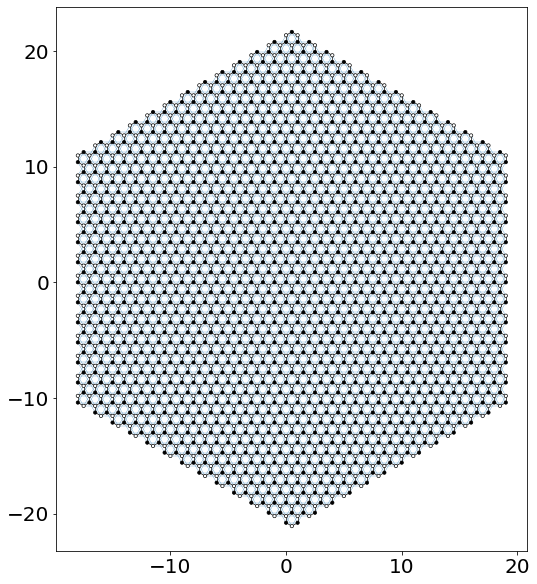

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
kwant.plot(system_armchair,
           site_size = family_size,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax);

In [81]:
Hmatrix_armchair = system_armchair.finalized().hamiltonian_submatrix(params=parameters_wo_B)

In [82]:
values_without_adatom, _ = la.eigh(Hmatrix_armchair) ## it take a lot of time

In [83]:
dos_test_without_adatom = DOS_manual(Energies, values_without_adatom, eps=0.1)

(-0.5, 0.5)

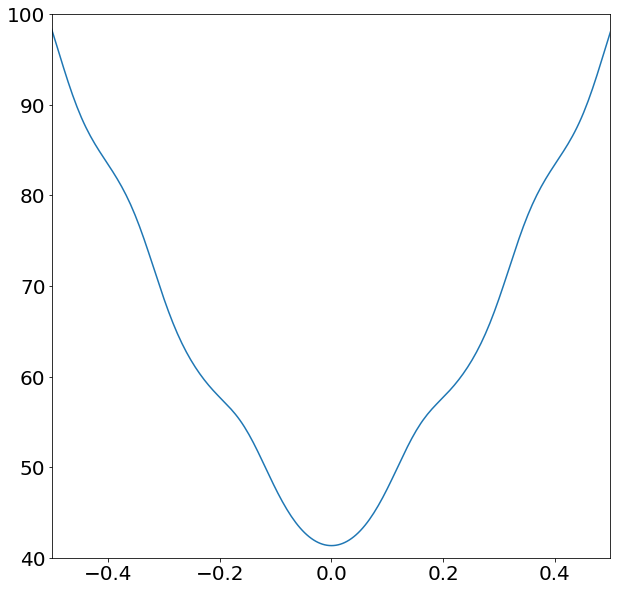

In [113]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Energies, dos_test_without_adatom, '-')
ax.set_ylim(40,100)
ax.set_xlim(-0.5,0.5)

In [86]:
insert_adatom(system_armchair, pos_tag, sub_lat,  **adatom_params)

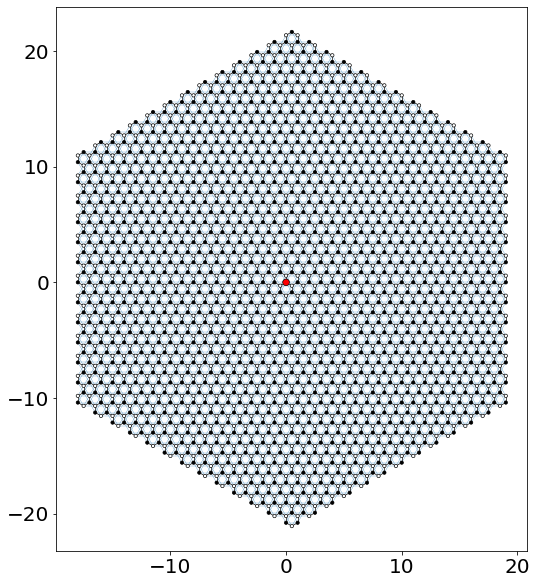

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
kwant.plot(system_armchair,
           site_size = family_size,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
# ax.set_xlim(-5,5)
# ax.set_ylim(-5,5)
# plt.savefig('system_long.png', dpi=200)
plt.show()

In [88]:
Hmatrix_armchair = system_armchair.finalized().hamiltonian_submatrix(params=parameters_wo_B)

In [89]:
Hmatrix_armchair.shape

(5630, 5630)

In [90]:
100 * 1/(Hmatrix_armchair.shape[0]/2 - 1)

0.03553660270078181

In [91]:
values_with_adatom, vectors = la.eigh(Hmatrix_armchair) ## it take a lot of time

In [92]:
dos_test_with_adatoms = DOS_manual(Energies, values_with_adatom, eps=0.1)

(-0.3, 0.3)

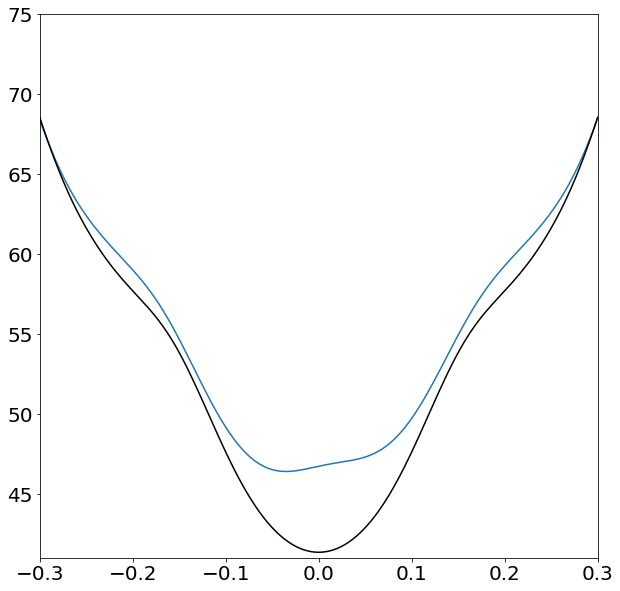

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Energies, dos_test_with_adatoms, '-')
ax.plot(Energies, dos_test_without_adatom, '-', c='k')
ax.set_ylim(41,75)
ax.set_xlim(-0.3,0.3)

In [94]:
pos_tag2 = (+5,0)
pos_tag3 = (-5,0)
insert_adatom(system_armchair, pos_tag2, sub_lat,  **adatom_params)
insert_adatom(system_armchair, pos_tag3, sub_lat,  **adatom_params)

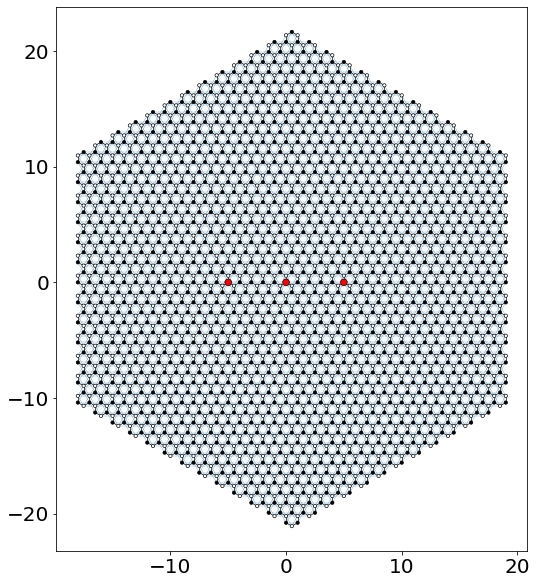

In [95]:
fig, ax = plt.subplots(figsize=(10,10))
kwant.plot(system_armchair,
           site_size = family_size,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
# ax.set_xlim(-5,5)
# ax.set_ylim(-5,5)
# plt.savefig('system_long.png', dpi=200)
plt.show()

In [96]:
type(system_armchair.sites())

dict_keys

In [97]:
len(system_armchair.sites())

2817

In [98]:
Hmatrix_armchair = system_armchair.finalized().hamiltonian_submatrix(params=parameters_wo_B)
Hmatrix_armchair.shape

(5634, 5634)

In [99]:
nsites = 0
for k in system_armchair.sites():
    nsites += 1

In [100]:
nsites * 2

5634

In [101]:
3/(nsites-3)

0.0010660980810234541

In [102]:
values_with_3_adatoms,_ = la.eigh(Hmatrix_armchair) ## it take a lot of time

In [103]:
dos_test_with_3_adatoms = DOS_manual(Energies, values_with_3_adatoms, eps=0.1)

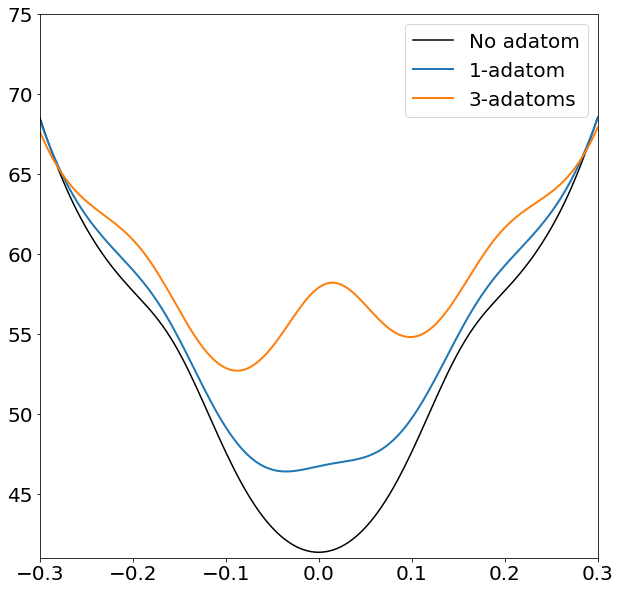

In [114]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Energies, dos_test_without_adatom, '-', c='k', label='No adatom')
ax.plot(Energies, dos_test_with_adatoms, '-', lw=2, label='1-adatom')
ax.plot(Energies, dos_test_with_3_adatoms, '-', lw=2, label='3-adatoms')

ax.set_ylim(41,75)
ax.set_xlim(-0.3,0.3)
ax.legend(fontsize=20)

In [2]:
import scipy.sparse.linalg as sla

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [ ]:
sla.eigsh()

### Transport calculation

In [46]:
## L-Lead modes:
# fig, ax = plt.subplots(figsize=(8,5))
# params_lead_0_hand = dict(t=1,
#                           B=0.5*np.pi,
#                           peierls_lead_L=peierls_lead_L,
#                           Lm=3,
#                          )
# lead_0 = leads[0].finalized()
# kwant.plotter.bands(lead_0, params=params_lead_0_hand, ax=ax)
# ax.set_ylabel('Energy [eV]')
# ax.set_xlabel(r'$k_x$ [1/a]')
# plt.savefig('energy_dispersion_left_lead.png', dpi=200)

## Getting the neighbors of the C_H's

## Including the SOC terms induced by the adatoms

In [47]:
def include_ASO_sitewise(system, CH_site, NNN_site, hop_list, Lambda_I=1):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NNN_site
        2. Returns an updated hop_list
    
    Naturaly, the first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (CH_site, NNN_site) not in hop_list: 

        # 2.1. Identify the hopping 1/2
        delta_tag = list(NNN_site.tag - CH_site.tag)
        if delta_tag in ([0,1], [1,-1], [-1,0]): sign = -1
        else: sign = +1
        
        # 2.2. Identify the hopping 2/2
        family_id  = 1 - 2 * int(CH_site.family.name[-1]) ## 1 (-1) if sublattice == A (B)
        
        # 3. Define the hopping
        H_asoc = sign * family_id * 1j/3 * Lambda_I/np.sqrt(3) * sigma_z # clockwise    
        system[CH_site, NNN_site] = H_asoc ## sytem[sublat_1(target), sublat_2(source)]
        
#         peierls_1(Site1, Site2, B, Lm)
        
        # 4. Save pairs in hop_list
        hop_list.append((CH_site, NNN_site)) # (CH, NNN)
        hop_list.append((NNN_site, CH_site)) # (NNN, CH)
        
    return hop_list


def include_BR_sitewise(system, CH_site, NN_site, hop_list, Lambda_BR=1):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NN_site
        2. Returns an updated hop_list
    
    The first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (CH_site, NN_site) not in hop_list:
        
        # 2. Identify the hopping 2/2:
        dx, dy = np.sqrt(3) * (CH_site.pos - NN_site.pos) 
        H_BR = (2j/3) * Lambda_BR * (dy * sigma_x - dx * sigma_y) ## (S X d_ij)_z 
        
        # 3. Define the hopping
        system[CH_site, NN_site] += H_BR
        
        # 4. Save pairs in hop_list
        hop_list.append((CH_site, NN_site)) # (CH, NNN)
        hop_list.append((NN_site, CH_site)) # (NNN, CH)
        
    return hop_list


def include_PIA_sitewise(system, site_target, site_source, hop_list, Lambda_PIA=1):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NN_site
        2. Returns an updated hop_list
    
    The first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (site_target, site_source) not in hop_list:
        
        # 2. Identify the hopping:
        Dx, Dy = site_target.pos - site_source.pos
        
        # 3. Define the hopping
        H_PIA =  2j/3 * Lambda_PIA * (Dy * sigma_x - Dx * sigma_y) ## (S x D_ij)_z
        system[site_target, site_source] += H_PIA
        
        # 4. Save pairs in hop_list
        hop_list.append((site_target, site_source)) # (site1, site2)
        hop_list.append((site_source, site_target)) # (site2, site1)
        
    return hop_list

#### Adatom induced spin-orbit coupling (ASO)

In [48]:
## Calculate and include the Adatom induced spin-orbit coupling
hop_list_ASO = []
for CH_site, NNN_sites in zip(CH_sites, all_NNN_neighbors):
    for NNN_site in NNN_sites:
#         print(CH_site,'--', NNN_site)
        include_ASO_sitewise(system, CH_site, NNN_site, hop_list_ASO, Lambda_I=1)

NameError: name 'CH_sites' is not defined

In [ ]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

#### Bychkov-Rashba spin-orbit coupling (BR)

In [ ]:
## Calculate and include into the system the Bychkov-Rashba spin-orbit coupling (BR)
hop_list_BR = []
for CH_site, NN_sites in zip(CH_sites, all_NN_neighbors):
    print(len(NN_sites))
    for NN_site in NN_sites:
        print(NN_site)
        include_BR_sitewise(system, CH_site, NN_site, hop_list_BR, Lambda_BR=1)

In [ ]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

### Pseudo-spin inversion asymmetry SOC (PIA)

In [ ]:
## Calculate and include into the system the Pseudo-spin inversion asymmetry spin-orbit coupling (PIA)
hop_list_PIA = []
for NN_sites in all_NN_neighbors:
    targets = [NN_sites[(i+1)%3] for i in range(3)]
    for site1, site2 in zip(targets, NN_sites):
        print(site1, '<--', site2)
        include_PIA_sitewise(system, site1, site2, hop_list_PIA, Lambda_PIA=1)

In [ ]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

## Checking the hoppings

## Considerations:

In [ ]:
# Make the system
sin_30 = 1/2
cos_30 = np.sqrt(3)/2

graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site (spin)
                                 name='Graphene'                       # name of identification
                                )
## Split in sublattices:
A, B = graphene.sublattices

## Define the shape of the system:
shape = Rectangle(W=1000, L=5)

## Build the scattering region:
system = make_graphene_strip(graphene, shape, t=2.6, iso=1e-6)

## Make the leads:
# leads  = make_graphene_leads(graphene, shape.leads, t=2.6, on_site=0, iso=1e-6)

## Attach the leads:
# for lead in leads:
#     system.attach_lead(lead)
    

pos_tag = (0,0)  # tag for the adatom
sub_lat = A      # sublattice of adatom
adatom_params = dict(t = 2.6, 
                     l_iso = 12e-6, 
                     T = 7.5, 
                     L_I = -0.21e-3, 
                     L_BR = 0.33e-3, 
                     L_PIA = -0.77e-3
                    )
insert_adatom(system, pos_tag, sub_lat, **adatom_params)

In [ ]:
wrapped = kwant.wraparound.wraparound(system).finalized()

In [ ]:
kwant.wraparound.plot_2d_bands(wrapped, params=parameters_wo_B)
# energies, densities = spectrum(param)
# energies_subset = np.linspace(-1,1,201)
# densities_subset = spectrum(energies_subset)

In [ ]:
type(wrapped)

In [ ]:
lat = kwant.lattice.honeycomb()
sym = kwant.TranslationalSymmetry(lat.vec((1, 0)), lat.vec((0, 1)))

bulk = kwant.Builder(sym)
bulk[ [lat.a(0, 0), lat.b(0, 0)] ] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()
kwant.wraparound.plot_2d_bands(wrapped)